In [35]:
import xml.etree.ElementTree as ET
import spacy
from spacy.lang.zh.examples import sentences

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

import torch
from torch.nn.utils.rnn import pad_sequence # not from scratch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import random
import os

from tqdm import tqdm

import sys
import matplotlib.pyplot as plt
from scipy.stats import mode

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
english_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/english_tags.csv')
mandarin_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/mandarin_tags.csv')
in_between_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/in_between_tags.csv')
en1_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/new_en1.csv')
zh1_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/new_zh1.csv')

# SYNTHETIC DATASET
sse_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sse_sentences.csv')
sle_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sle_sentences.csv')

<ipython-input-37-cb521b751560>:1: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248) have mixed types. Specify dtype option on import or set low_memory=False.
  english_tags_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/english_tags.csv')
<ipython-input-37-cb521b751560>:2: DtypeWarning: Columns (47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76

In [38]:
# DROP COLUMNS
sse_df = sse_df.drop(columns=["Sentence"])
sse_df = sse_df.rename(columns={"Sentence.1": "Sentence"})
sle_df = sle_df.rename(columns={"0": "Sentence"})
sse_df

,Sentence
0,I am eating a sandwich for lunch today.
1,I went to the mall with my mom and bought a ne...
2,My friends and I like to hang out at the park ...
3,I eat my sandwich and fruit for lunch every day
4,I love spending time with my friends at the park.
...,...
2452,I am making dinner in the kitchen by cooking a...
2453,We are going to the movies tonight to see a ne...
2454,I eat a sandwich for lunch every day
2455,I am cooking a yummy pasta dish for dinner.


In [39]:
sle_df = sle_df.rename(columns={"0": "Sentence"})

In [40]:
sle_df

,Sentence
0,I very like to play basketball at weekend.
1,I very like play basketball with my friend.
2,I go to shopping yesterday.
3,I go to the store every day for buy food.
4,I go to library every day after school.
...,...
2495,I go to shop yesterday for buy fruits.
2496,I am very interesting in this subject.
2497,I go to shop yesterday for buy fruit.
2498,She very like play basketball with friends.


In [41]:
# ASSIGN POS TAGS TO SENTENCES IN SYNTHETIC DATASET
nlp_en = spacy.load('en_core_web_sm')

sse_sentences = sse_df['Sentence'].tolist()
sle_sentences = sle_df['Sentence'].tolist()

sse_tags_df = [ [token.pos_ for token in nlp_en(sentence)] for sentence in sse_sentences]
sle_tags_df = [ [token.pos_ for token in nlp_en(sentence)] for sentence in sle_sentences]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [42]:
# FILTER SENTENCES FOR SPECIFIC LENGTHS

# GLOBAL VOICES EN
row_lengths = english_tags_df.apply(lambda row: row.count(), axis=1)
filtered_english_tags_df = english_tags_df[(row_lengths >= 4) & (row_lengths <= 100)]

# GLOBAL VOICES ZH
row_lengths = mandarin_tags_df.apply(lambda row: row.count(), axis=1)
filtered_mandarin_tags_df = mandarin_tags_df[(row_lengths >= 2) & (row_lengths <= 60)]

# TLE
row_lengths = in_between_tags_df.apply(lambda row: row.count(), axis=1)
filtered_inbtwn_tags_df = in_between_tags_df[(row_lengths >= 2) & (row_lengths <= 50)]

# MAC EN
row_lengths = en1_df.apply(lambda row: row.count(), axis=1)
filtered_mac_en_tags_df = en1_df[(row_lengths >= 2) & (row_lengths <= 60)]

# MAC ZH
row_lengths = zh1_df.apply(lambda row: row.count(), axis=1)
filtered_mac_zh_tags_df = zh1_df[(row_lengths >= 2) & (row_lengths <= 70)]

In [43]:
# LENGTH CHECK
print(f'Length of GLOBAL VOICES EN tags', len(filtered_english_tags_df))
print(f'Length of GLOBAL VOICES ZH tags', len(filtered_mandarin_tags_df))
print(f'Length of TLE tags', len(filtered_inbtwn_tags_df))
print(f'Length of MAC EN tags', len(filtered_mac_en_tags_df))
print(f'Length of MAC ZH tags', len(filtered_mac_zh_tags_df))

print(f'Length of SSE tags', len(sse_df))
print(f'Length of SLE tags', len(sle_df))

Length of GLOBAL VOICES EN tags 137169
Length of GLOBAL VOICES ZH tags 138636
Length of TLE tags 2117
Length of MAC EN tags 5789
Length of MAC ZH tags 4322
Length of SSE tags 2457
Length of SLE tags 2500


In [44]:
# POS TAGGING FLOW
all_tags = pd.Series(english_tags_df.values.flatten())
unique_tags = all_tags.unique()
num_tags = len(unique_tags)
print("Number of unique POS tags:", num_tags)
print("Unique POS tags:", unique_tags)

all_tags_zh = pd.Series(mandarin_tags_df.values.flatten())
unique_tags_zh = all_tags_zh.unique()
num_tags_zh = len(unique_tags_zh)
print("Number of unique Mandarin POS tags:", num_tags_zh)
print("Unique POS Mandarin tags:", unique_tags_zh)

intersection = list(set(unique_tags) & set(unique_tags_zh))
print("Intersection:", intersection)
print(len(intersection))

difference = list(set(unique_tags) - set(intersection))

# Print the result
print("Elements in unique_tags but not in intersection:", difference)

Number of unique POS tags: 19
Unique POS tags: ['DET' 'NOUN' 'ADP' 'VERB' 'ADJ' 'PROPN' 'CCONJ' 'PUNCT' 'SPACE' nan
 'SCONJ' 'AUX' 'NUM' 'ADV' 'PRON' 'PART' 'INTJ' 'X' 'SYM']
Number of unique Mandarin POS tags: 17
Unique POS Mandarin tags: ['PROPN' 'PART' 'VERB' 'PUNCT' 'SPACE' nan 'NOUN' 'PRON' 'ADV' 'NUM' 'ADP'
 'ADJ' 'X' 'DET' 'CCONJ' 'SCONJ' 'INTJ']
Intersection: ['PUNCT', 'X', 'CCONJ', 'ADP', 'NOUN', 'SCONJ', nan, 'DET', 'SPACE', 'ADV', 'PRON', 'NUM', 'PROPN', 'VERB', 'INTJ', 'PART', 'ADJ']
17
Elements in unique_tags but not in intersection: ['AUX', 'SYM']


In [45]:
# ONE HOT FLOW

# 17-POSITIONS
tag_order = []
for i, tag in enumerate(intersection):
    tag_order.append(tag)
print(tag_order)

['PUNCT', 'X', 'CCONJ', 'ADP', 'NOUN', 'SCONJ', nan, 'DET', 'SPACE', 'ADV', 'PRON', 'NUM', 'PROPN', 'VERB', 'INTJ', 'PART', 'ADJ']


In [46]:
pos_to_index = {}
for i, tag in enumerate(unique_tags):
    pos_to_index[tag] = i

def pos_to_one_hot(pos_tag, pos_to_index, num_tags):
    one_hot = np.zeros(num_tags)
    index = pos_to_index[pos_tag]
    one_hot[index] = 1
    return one_hot

In [47]:
sse_tags_df = pd.DataFrame(sse_tags_df)
print(type(sse_tags_df))

<class 'pandas.core.frame.DataFrame'>


In [48]:
sle_tags_df = pd.DataFrame(sle_tags_df)
print(type(sse_tags_df))

<class 'pandas.core.frame.DataFrame'>


In [49]:
from re import template
# APPLY ONE-HOT FUNCTION TO ALL TRAINING SENTENCES
english_tags = filtered_english_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
mandarin_tags = filtered_mandarin_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
tle_tags = filtered_inbtwn_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
mac_en_tags = filtered_mac_en_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
mac_zh_tags = filtered_mac_zh_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
sse_tags = sse_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
sle_tags = sle_tags_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

In [50]:
# CONVERT INDIVIDUAL POS TAGS TO A MATRIX
def matrixify(tags):
  sentence_matrices = []

  for sentence_tags in tags:
      one_hot_vectors = []

      for tag in sentence_tags:
          one_hot_vector = pos_to_one_hot(tag, pos_to_index, num_tags)
          one_hot_vectors.append(one_hot_vector)

      sentence_matrix = np.array(one_hot_vectors)
      sentence_matrices.append(sentence_matrix)

  return sentence_matrices

In [51]:
sentence_matrices_en = matrixify(english_tags)
sentence_matrices_zh = matrixify(mandarin_tags)
sentence_matrices_tle = matrixify(tle_tags)
sentence_matrices_mac_en = matrixify(mac_en_tags)
sentence_matrices_mac_zh = matrixify(mac_zh_tags)

In [52]:
sentence_matrices_sse = matrixify(sse_tags)
sentence_matrices_sle = matrixify(sle_tags)

In [53]:
# CREATE CLASSIFICATION LABEL FOR EN/ZH || [1]/[0]
en_labels = [1] * len(sentence_matrices_en)
zh_labels = [0] * len(sentence_matrices_zh)
all_sentences_en_zh = sentence_matrices_en + sentence_matrices_zh
all_labels_en_zh = en_labels + zh_labels

mac_en_labels = [1] * len(sentence_matrices_mac_en)
mac_zh_labels = [0] * len(sentence_matrices_mac_zh)
all_sentences_mac = sentence_matrices_mac_en + sentence_matrices_mac_zh
all_labels_mac = mac_en_labels + mac_zh_labels

  # use for validation later
tle_assume_en = [1] * len(sentence_matrices_tle)
tle_assume_zh = [0] * len(sentence_matrices_tle)

# synthetic dataset
sse_labels = [1] * len(sentence_matrices_sse)
sle_labels = [1] * len(sentence_matrices_sle)

In [54]:
# PAD SENTENCE LENGTHS
def collate_fn(batch):
    # Extract sentences and labels from the batch
    sentences, labels = zip(*batch)

    # Pad sentences to the same length along the first dimension (number of words)
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)

    # Stack the labels into a tensor
    labels = torch.stack(labels)

    return padded_sentences, labels

In [55]:
# PROCESS TENSORS + ATTACH MATRIX-LABEL CORRESSPONDENCE
class POSDataset(Dataset):
    def __init__(self, sentence_matrices, labels):

        # Convert sentence matrices to PyTorch tensors
        sentence_tensors = []
        for matrix in sentence_matrices:
            sentence_tensor = torch.tensor(matrix, dtype=torch.float32)
            sentence_tensors.append(sentence_tensor)
        self.sentence_matrices = sentence_tensors

        # Convert labels to a 1D PyTorch tensor (flatten)
        label_list = []
        for label in labels:
            label_list.append(label)
        self.labels = torch.tensor(label_list, dtype=torch.long)

    def __len__(self):
        return len(self.sentence_matrices)

    # correspondence est here because indices are processed in order
    def __getitem__(self, index):
        return self.sentence_matrices[index], self.labels[index]

In [56]:
batch_size=4

In [63]:
from torch.utils.data import Subset
import random

# Randomly select 20% of the dataset
def get_subset(dataset, percentage=0.2):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    indices = list(range(total_size))
    random.shuffle(indices)  # Shuffle indices randomly
    selected_indices = indices[:subset_size]  # Pick the first `subset_size` indices
    return Subset(dataset, selected_indices)

In [64]:
global_voices = POSDataset(all_sentences_en_zh, all_labels_en_zh)

indices = list(range(len(global_voices)))
random.shuffle(indices)

train_size = int(0.8 * len(global_voices))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create subsets for train and test
train_dataset = Subset(global_voices, train_indices)
test_dataset = Subset(global_voices, test_indices)

# Create DataLoader objects for train and test datasets
train_loader_global_voices = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader_global_voices = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# ENGLISH GLOBAL VOICES SENTENCES
global_voices_en_sentences_full = POSDataset(sentence_matrices_en, en_labels)
global_voices_en_sentences = get_subset(global_voices_en_sentences_full, percentage=0.2)
loader_global_voices_en_sentences = DataLoader(global_voices_en_sentences, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [65]:
# ADD CODE HERE LATER TO EVALUATE THE DATASET
# Properly format MAC dataset
mac_sentences = POSDataset(all_sentences_mac, all_labels_mac)
loader_mac_sentences = DataLoader(mac_sentences, batch_size=1, shuffle=True, collate_fn=collate_fn)

# ENGLISH MAC SENTENCES
mac_en_sentences = POSDataset(sentence_matrices_mac_en, mac_en_labels)
loader_mac_en_sentences = DataLoader(mac_en_sentences, batch_size=1, shuffle=True, collate_fn=collate_fn)

tle_sentences = POSDataset(sentence_matrices_tle, tle_assume_en)
loader_tle_sentences = DataLoader(tle_sentences, batch_size=1, shuffle=True, collate_fn=collate_fn)

sse_sentences = POSDataset(sentence_matrices_sse, sse_labels)
loader_sse_sentences = DataLoader(sse_sentences, batch_size=1, shuffle=True, collate_fn=collate_fn)

sle_sentences = POSDataset(sentence_matrices_sle, sle_labels)
loader_sle_sentences = DataLoader(sle_sentences, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [59]:
# RNN MODEL CREATION
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        # no bias in linear layer as the hidden_state compensates
        self.i2h = nn.Linear(input_size, hidden_size, bias=False) # input to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size) # hidden to hidden
        self.h2o = nn.Linear(hidden_size, output_size) # hidden to output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden_state):
    # x: [batch_size, input_size]
    # hidden_state: [batch_size, hidden_size]
      x = self.i2h(x)  # [batch_size, hidden_size]
      hidden_state = self.h2h(hidden_state)  # [batch_size, hidden_size]
      hidden_state = torch.tanh(x + hidden_state)  # [batch_size, hidden_size]
      output = self.h2o(hidden_state)  # [batch_size, output_size]
      return self.softmax(output), hidden_state

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


In [61]:
# IMPLEMENT RNN TRAINING
  # hyperparameters
input_size = all_sentences_en_zh[0].shape[1] # length of a one-hot vector: 17
hidden_size = 16
output_size = 2 # either 1 or 0, binary classification

model = RNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fct = nn.NLLLoss()

In [ ]:
# TRAINING
def train_model(model, train_loader, epochs, optimizer, loss_fct, checkpoint_dir='/content/drive/My Drive/IW_Codebase/checkpoints'):
    model.train()
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(epochs):
        total_loss = 0

        # initialize tqdm progress bar for training loop
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=True)

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            hidden = model.init_hidden(batch_size).to(device)

            # zero gradients
            optimizer.zero_grad()

            # process each step in the seq
            loss = 0
            for i in range(X.size(1)):
                output, hidden = model(X[:, i, :], hidden)
                loss += loss_fct(output, y)

            # backprop + update weights
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3)  # gradient clipping for performance
            optimizer.step()

            total_loss += loss.item() / X.size(1)

            progress_bar.set_postfix(loss=loss.item() / X.size(1))

        # Save model checkpoint at the end of each epoch with a unique filename
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model weights for epoch {epoch + 1} saved to {checkpoint_path}')

        # Print epoch loss
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

    final_checkpoint_path = os.path.join(checkpoint_dir, 'final_model_weights.pth')
    torch.save(model.state_dict(), final_checkpoint_path)
    print(f'Final model weights saved to {final_checkpoint_path}')

In [ ]:
train_model(model, train_loader_global_voices, epochs=10, optimizer=optimizer, loss_fct=loss_fct)

Epoch 1/10: 100%|██████████| 55161/55161 [20:10<00:00, 45.57it/s, loss=0.0268]


Model weights for epoch 1 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_1.pth
Epoch 1/10, Loss: 0.2992


Epoch 2/10: 100%|██████████| 55161/55161 [20:02<00:00, 45.87it/s, loss=2.26]


Model weights for epoch 2 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_2.pth
Epoch 2/10, Loss: 0.2797


Epoch 3/10: 100%|██████████| 55161/55161 [20:02<00:00, 45.88it/s, loss=1.44]


Model weights for epoch 3 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_3.pth
Epoch 3/10, Loss: 0.2753


Epoch 4/10: 100%|██████████| 55161/55161 [20:01<00:00, 45.90it/s, loss=0.111]


Model weights for epoch 4 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_4.pth
Epoch 4/10, Loss: 0.2726


Epoch 5/10: 100%|██████████| 55161/55161 [20:10<00:00, 45.56it/s, loss=0.0799]


Model weights for epoch 5 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_5.pth
Epoch 5/10, Loss: 0.2735


Epoch 6/10: 100%|██████████| 55161/55161 [20:10<00:00, 45.58it/s, loss=0.741]


Model weights for epoch 6 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_6.pth
Epoch 6/10, Loss: 0.2746


Epoch 7/10: 100%|██████████| 55161/55161 [20:04<00:00, 45.78it/s, loss=0.008]


Model weights for epoch 7 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_7.pth
Epoch 7/10, Loss: 0.2753


Epoch 8/10: 100%|██████████| 55161/55161 [20:07<00:00, 45.68it/s, loss=0.0989]


Model weights for epoch 8 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_8.pth
Epoch 8/10, Loss: 0.2777


Epoch 9/10: 100%|██████████| 55161/55161 [20:02<00:00, 45.88it/s, loss=0.0285]


Model weights for epoch 9 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_9.pth
Epoch 9/10, Loss: 0.2775


Epoch 10/10: 100%|██████████| 55161/55161 [19:58<00:00, 46.02it/s, loss=0.0651]


Model weights for epoch 10 saved to /content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_10.pth
Epoch 10/10, Loss: 0.2737
Final model weights saved to /content/drive/My Drive/IW_Codebase/checkpoints/final_model_weights.pth


In [ ]:
# EVALUATE THE SAVED WEIGHTS
model = RNN(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_6.pth'))
model.eval()

<ipython-input-31-8e7c0647fd57>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/IW_Codebase/checkpoints/model_epoc

RNN(
  (i2h): Linear(in_features=19, out_features=16, bias=False)
  (h2h): Linear(in_features=16, out_features=16, bias=True)
  (h2o): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [62]:
# PREDICTION FUNCTION
def predict(model, sentence_tensor):
    model.eval()
    with torch.no_grad():
        sentence_tensor = sentence_tensor.to(device)
        batch_size = sentence_tensor.size(0)
        hidden = model.init_hidden(batch_size).to(device)

        for i in range(sentence_tensor.size(1)):
            output, hidden = model(sentence_tensor[:, i, :], hidden)

        # Probability system
        probabilities = torch.exp(output) # exponentiate the log probabilities
        return probabilities

In [ ]:
def output_metrics(df):
  correct_confidence = df[df["Predicted"] == df["True Label"]]["Confidence"].mean()
  print(f"Mean Confidence for Correct Predictions: {correct_confidence:.4f}")
  # Calculate accuracy
  accuracy = correct_predictions / total_predictions

  # Calculate correct confidence
  correct_confidence = df[df["Predicted"] == df["True Label"]]["Confidence"].mean()

  # Calculate weighted score
  weighted_score = accuracy * correct_confidence
  print(f"Weighted Score: {weighted_score:.4f}")

In [136]:
# LOOP FOR EVALUATION + CHART

def evaluate_model(model, dataloader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for sentence_tensor, labels in dataloader:
      # move tensors to device
      sentence_tensor = sentence_tensor.to(device)
      labels = labels.to(device)

      # get pr from model
      probabilities = predict(model, sentence_tensor)
      predicted_labels = (probabilities[:, 1] > 0.5).long()

      # compare with true labels
      correct += (predicted_labels == labels).sum().item()
      total += labels.size(0)
  return correct/total

collect_accuracies_global_voices = []
collect_accuracies_mac = []
collect_accuracies_tle = []
collect_accuracies_sse = []
collect_accuracies_sle = []

for epoch in range(1,11): # loop from 1 to 10
  weight_path = f"/content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_{epoch}.pth"
  model.load_state_dict(torch.load(weight_path))
  model.to(device)

  accuracy_global_voices = evaluate_model(model, test_loader_global_voices)
  accuracy_mac = evaluate_model(model, loader_mac_sentences)
  accuracy_tle = evaluate_model(model, loader_tle_sentences)
  accuracy_sse = evaluate_model(model, loader_sse_sentences)
  accuracy_sle = evaluate_model(model, loader_sle_sentences)

  collect_accuracies_global_voices.append(accuracy_global_voices)
  collect_accuracies_mac.append(accuracy_mac)
  collect_accuracies_tle.append(accuracy_tle)
  collect_accuracies_sse.append(accuracy_sse)
  collect_accuracies_sle.append(accuracy_sle)

data = {
    'Global Voices': collect_accuracies_global_voices,
    'MAC': collect_accuracies_mac,
    'TLE': collect_accuracies_tle,
    'Synthetic Standard English': collect_accuracies_sse,
    'Synthetic Learner English': collect_accuracies_sle
}

df = pd.DataFrame(data)

<ipython-input-136-49f5f7720d51>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


KeyboardInterrupt: 

In [137]:
# LOOP FOR EVALUATION + CHART

def evaluate_model(model, dataloader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for sentence_tensor, labels in dataloader:
      # move tensors to device
      sentence_tensor = sentence_tensor.to(device)
      labels = labels.to(device)

      # get pr from model
      probabilities = predict(model, sentence_tensor)
      predicted_labels = (probabilities[:, 1] > 0.5).long()

      # compare with true labels
      correct += (predicted_labels == labels).sum().item()
      total += labels.size(0)
  return correct/total

collect_accuracies_sle = []

for epoch in range(1,11): # loop from 1 to 10
  weight_path = f"/content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_{epoch}.pth"
  model.load_state_dict(torch.load(weight_path))
  model.to(device)

  accuracy_sle = evaluate_model(model, loader_sle_sentences)

  collect_accuracies_sle.append(accuracy_sle)

<ipython-input-137-5a6784151d67>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


In [138]:
print(collect_accuracies_sse)
print(collect_accuracies_sle)

[]
[0.7592, 0.8048, 0.7632, 0.7664, 0.7796, 0.7552, 0.7616, 0.6936, 0.7284, 0.656]


In [141]:
df["Synthetic Learner English"] = collect_accuracies_sle

In [142]:
df.index = df.index + 1
df

,Global Voices,MAC,TLE,Synthetic Standard English,Synthetic Learner English
1,0.953318,0.943626,0.964100,0.859178,0.7592
2,0.953518,0.939769,0.969769,0.881156,0.8048
3,0.955367,0.944813,0.966462,0.901913,0.7632
4,0.952684,0.937988,0.969296,0.917379,0.7664
5,0.955222,0.943032,0.969769,0.923891,0.7796
6,0.954914,0.953714,0.959376,0.929589,0.7552
7,0.957325,0.954604,0.961738,0.930810,0.7616
8,0.959664,0.954010,0.966934,0.940985,0.6936
9,0.960171,0.951934,0.973547,0.956044,0.7284
10,0.960062,0.962615,0.965045,0.918600,0.6560


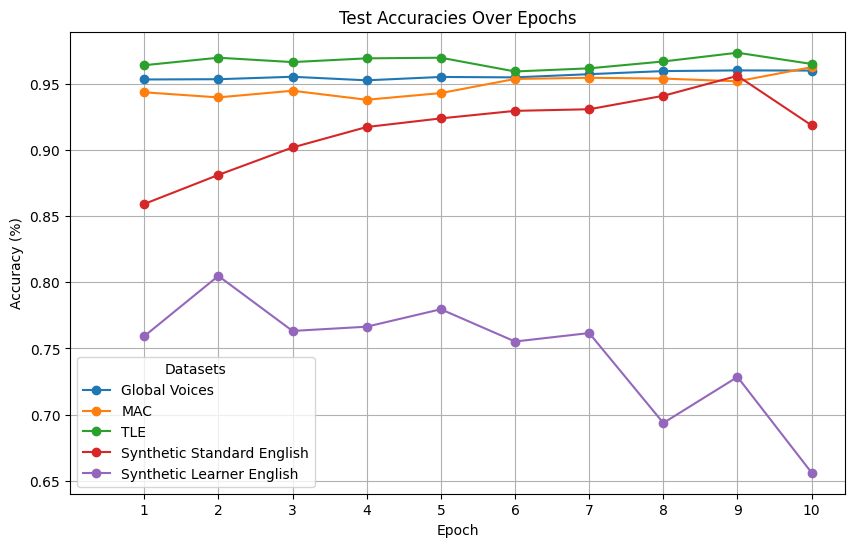

In [143]:
# Plot the DataFrame
df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Test Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(title='Datasets')
plt.grid(True)

plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.xlim(0, None)
plt.show()

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

# LOOP FOR EVALUATION
weight_path = f"/content/drive/My Drive/IW_Codebase/checkpoints/model_epoch_4.pth"
model.load_state_dict(torch.load(weight_path))
model.to(device)

def get_stats(model, dataloader, name=""):
  model.eval()
  results = []
  true_labels = []
  predicted_labels_list = []

  with torch.no_grad():
      correct_predictions = 0
      total_predictions = 0

      for sentence_tensors, labels in dataloader:
          # Move tensors to device
          sentence_tensors = sentence_tensors.to(device)
          labels = labels.to(device)

          # Get probabilities from model
          probabilities = predict(model, sentence_tensors)
          predicted_labels = (probabilities[:, 1] > 0.5).long()
          confidence_scores = probabilities.max(dim=1).values

          correct_predictions += (predicted_labels == labels).sum().item()
          total_predictions += labels.size(0)

          # Collect true and predicted labels for metrics
          true_labels.extend(labels.cpu().numpy())
          predicted_labels_list.extend(predicted_labels.cpu().numpy())

          for prob, pred, true_label, conf in zip(probabilities, predicted_labels, labels, confidence_scores):
              results.append({
                  "Probability of 0": prob[0].item(),
                  "Probability of 1": prob[1].item(),
                  "Predicted": pred.item(),
                  "True Label": true_label.item(),
                  "Confidence": conf.item()
              })

  accuracy = correct_predictions / total_predictions
  precision = precision_score(true_labels, predicted_labels_list, pos_label=1)
  recall = recall_score(true_labels, predicted_labels_list, pos_label=1)
  f1 = f1_score(true_labels, predicted_labels_list, pos_label=1)
  f05 = fbeta_score(true_labels, predicted_labels_list, beta=0.5, pos_label=1)
  df = pd.DataFrame(results)

  # Save results in a dictionary
  stats = {
      "Dataset": name,
      "Accuracy": accuracy,
      "Precision": precision,
      "Recall": recall,
      "F1 Score": f1,
      "F0.5 Score": f05
  }
  return stats

dataloaders = {
    "Global Voices": loader_global_voices_en_sentences,
    "MAC Sentences": loader_mac_en_sentences,
    "TLE Sentences": loader_tle_sentences,
    "SSE Sentences": loader_sse_sentences,
    "SLE Sentences": loader_sle_sentences
}

all_stats = []

for name, dataloader in dataloaders.items():
    stats = get_stats(model, dataloader, name)
    all_stats.append(stats)

# Convert results to a DataFrame for easy display
df_stats = pd.DataFrame(all_stats)
print(df_stats)

<ipython-input-67-45c4c73feb7f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


         Dataset  Accuracy  Precision    Recall  F1 Score  F0.5 Score
0  Global Voices  0.954398        1.0  0.954398  0.976667    0.990534
1  MAC Sentences  0.971498        1.0  0.971498  0.985543    0.994167
2  TLE Sentences  0.969296        1.0  0.969296  0.984409    0.993705
3  SSE Sentences  0.917379        1.0  0.917379  0.956909    0.982306
4  SLE Sentences  0.766400        1.0  0.766400  0.867754    0.942542


In [ ]:
df

,Probability of 0,Probability of 1,Predicted,True Label,Confidence
0,0.000088,0.999912,1,1,0.999912
1,0.999692,0.000308,0,0,0.999692
2,0.999698,0.000302,0,0,0.999698
3,0.000206,0.999794,1,1,0.999794
4,0.000131,0.999869,1,1,0.999869
...,...,...,...,...,...
55156,0.999708,0.000292,0,0,0.999708
55157,0.000248,0.999752,1,1,0.999752
55158,0.999712,0.000288,0,0,0.999712
55159,0.000118,0.999882,1,1,0.999882


In [ ]:
output_metrics(df)

Mean Confidence for Correct Predictions: 0.9967
Weighted Score: 0.9512


In [ ]:
# LOOP FOR EVALUATION
model.eval()

results = []

with torch.no_grad():
  correct_predictions = 0
  total_predictions = 0

  for sentence_tensors, labels in loader_mac_sentences:
    # move tensors to device
    sentence_tensors = sentence_tensors.to(device)
    labels = labels.to(device)

    # get pr from model
    probabilities = predict(model, sentence_tensors)
    predicted_labels = torch.argmax(probabilities, dim=1)
    confidence_scores = probabilities.max(dim=1).values

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += labels.size(0)

    for prob, pred, true_label, conf in zip(probabilities, predicted_labels, labels, confidence_scores):
      results.append({
                "Probability of 0": prob[0].item(),
                "Probability of 1": prob[1].item(),
                "Predicted": pred.item(),
                "True Label": true_label.item(),
                "Confidence": conf.item()
            })

df_mac = pd.DataFrame(results)

accuracy_mac = correct_predictions / total_predictions

In [ ]:
print(accuracy_mac)

0.9537137770744734


In [ ]:
df_mac

,Probability of 0,Probability of 1,Predicted,True Label,Confidence
0,0.000076,0.999924,1,1,0.999924
1,0.000150,0.999850,1,1,0.999850
2,0.974273,0.025727,0,0,0.974273
3,0.892705,0.107295,0,0,0.892705
4,0.000134,0.999866,1,1,0.999866
...,...,...,...,...,...
10106,0.000061,0.999939,1,1,0.999939
10107,0.998976,0.001024,0,0,0.998976
10108,0.013489,0.986511,1,0,0.986511
10109,0.000068,0.999932,1,1,0.999932


In [ ]:
output_metrics(df_mac)

Mean Confidence for Correct Predictions: 0.9896
Weighted Score: 0.9438


In [ ]:
print(f"Final Model Accuracy: {accuracy_mac:.4f}")

Final Model Accuracy: 0.9537


In [ ]:
# LOOP FOR EVALUATION
model.eval()

results = []

with torch.no_grad():
  correct_predictions = 0
  total_predictions = 0

  for sentence_tensors, labels in loader_tle_sentences:
    # move tensors to device
    sentence_tensors = sentence_tensors.to(device)
    labels = labels.to(device)

    # get pr from model
    probabilities = predict(model, sentence_tensors)
    predicted_labels = torch.argmax(probabilities, dim=1)
    confidence_scores = probabilities.max(dim=1).values

    correct_predictions += (predicted_labels == labels).sum().item()
    total_predictions += labels.size(0)

    for prob, pred, true_label, conf in zip(probabilities, predicted_labels, labels, confidence_scores):
      results.append({
                "Probability of 0": prob[0].item(),
                "Probability of 1": prob[1].item(),
                "Predicted": pred.item(),
                "True Label": true_label.item(),
                "Confidence": conf.item()
            })

df_tle = pd.DataFrame(results)

accuracy_tle = correct_predictions / total_predictions
print(f"Final Model Accuracy: {accuracy_tle:.4f}")

Final Model Accuracy: 0.9594


In [ ]:
output_metrics(df_tle)

Mean Confidence for Correct Predictions: 0.9923
Weighted Score: 0.9520


In [68]:
# HERE WE BEGIN THE RULE BASED EVALUATION

In [69]:
!ls "/content/drive/My Drive/IW_Codebase/rule_based_flow"

global_voices_en_sentences.csv	sle_sentences.csv  tle_sentences.csv
mac_en_sentences.csv		sse_sentences.csv


In [78]:
global_voices_sentences_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/global_voices_en_sentences.csv')
tle_sentences_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/tle_sentences.csv')
mac_sentences_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/mac_en_sentences.csv')

# SYNTHETIC DATASET
sse_sentences_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sse_sentences.csv')
sle_sentences_df = pd.read_csv('/content/drive/My Drive/IW_Codebase/rule_based_flow/sle_sentences.csv')

In [79]:
sse_sentences_df = sse_sentences_df.drop(columns=["Sentence"])
sse_sentences_df = sse_sentences_df.rename(columns={"Sentence.1": "Sentence"})
sle_sentences_df = sle_sentences_df.rename(columns={"0": "Sentence"})

In [82]:
sse_sentences = sse_sentences_df['Sentence'].tolist()

In [85]:
sse_test = sse_sentences[:10]
sse_test

['I am eating a sandwich for lunch today.',
 'I went to the mall with my mom and bought a new toy.',
 'My friends and I like to hang out at the park on weekends.',
 'I eat my sandwich and fruit for lunch every day',
 'I love spending time with my friends at the park.',
 'I play soccer with my friends every Saturday.',
 'I am making dinner in the kitchen. I am cooking chicken and vegetables.',
 'I like to play soccer with my friends on the weekends.',
 'I like hanging out with my friends at the park on weekends.',
 'I went to the mall with my family and bought a new toy.']

In [86]:
import sys
from importlib import reload

# Reset sys.path to its default state
sys = reload(sys)

# Check the reset sys.path
print("\n".join(sys.path))

/content
/env/python
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload

/usr/local/lib/python3.10/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.10/dist-packages/IPython/extensions
/usr/local/lib/python3.10/dist-packages/setuptools/_vendor
/root/.ipython
/tmp/tmpk1ham0vu


In [89]:
sys.path.append('/content/drive/My Drive/IW_Codebase/')
from rules_based_engine import check_sentences

In [90]:
results = check_sentences(sse_test)

for sentence, error_count in results.items():
    print(f"'{sentence}' has {error_count} error(s).")

Sentence: I am eating a sandwich for lunch today.
Tagged Tokens: [('I', 'PRP'), ('am', 'VBP'), ('eating', 'VBG'), ('a', 'DT'), ('sandwich', 'NN'), ('for', 'IN'), ('lunch', 'NN'), ('today', 'NN'), ('.', '.')]
Checking verb for 'I': ('am', 'VBP')
Rule check_subject_verb_agreement flagged 0 error(s).
Rule check_singular_plural_confusion flagged 0 error(s).
Rule check_verb_tense_confusion flagged 0 error(s).
Rule check_articles flagged 2 error(s).
Total Errors Detected: 2

Sentence: I went to the mall with my mom and bought a new toy.
Tagged Tokens: [('I', 'PRP'), ('went', 'VBD'), ('to', 'IN'), ('the', 'DT'), ('mall', 'NN'), ('with', 'IN'), ('my', 'PRP$'), ('mom', 'NN'), ('and', 'CC'), ('bought', 'VBD'), ('a', 'DT'), ('new', 'JJ'), ('toy', 'NN'), ('.', '.')]
Checking verb for 'I': ('went', 'VBD')
Rule check_subject_verb_agreement flagged 3 error(s).
Rule check_singular_plural_confusion flagged 0 error(s).
Rule check_verb_tense_confusion flagged 0 error(s).
Rule check_articles flagged 2 err